In [2]:
import numpy as np
import pylab
import time
import util
from scipy.special import gammaln


IMAGE_DIM = 28

TRAIN_IMAGES_FILE = 'train-images-idx3-ubyte'
TRAIN_LABELS_FILE = 'train-labels-idx1-ubyte'
TEST_IMAGES_FILE = 't10k-images-idx3-ubyte'
TEST_LABELS_FILE = 't10k-labels-idx1-ubyte'


def beta_log_pdf(theta, a, b):
    """Log PDF of the beta distribution. We don't need this function, but we
    include it in case you're interested. You need SciPy in order to use it."""
    norm_const = gammaln(a + b) - gammaln(a) - gammaln(b)
    return norm_const + (a - 1.) * np.log(theta) + (b - 1.) * np.log(1. - theta)

def beta_log_pdf_unnorm(theta, a, b):
    """Unnormalized log PDF of the beta distribution."""
    return (a - 1.) * np.log(theta) + (b - 1.) * np.log(1. - theta)

def dirichlet_log_pdf(pi, a):
    """Log PDF of the Dirichlet distribution. We don't need this function, but we
    include it in case you're interested. You need SciPy in order to use it."""
    norm_const = gammaln(a.sum()) - gammaln(a).sum()
    return norm_const + np.sum((a - 1.) * np.log(pi))

def dirichlet_log_pdf_unnorm(pi, a):
    """Unnormalized log PDF of the Dirichlet distribution."""
    return np.sum((a - 1.) * np.log(pi))





class Params(object):
    """A class which represents the trainable parameters of the mixture model.
        - pi: the mixing proportions, represented as a K-dimensional array. It must be a
            probability distribution, i.e. the entries must be nonnegative and sum to 1.
        - theta: The Bernoulli parameters for each pixel in each mixture component. This is
            a K x D matrix, where rows correspond to mixture components and columns correspond
            to pixels. """
    
    def __init__(self, pi, theta):
        self.pi = pi
        self.theta = theta

    @classmethod
    def random_initialization(cls, num_components, num_pixels):
        init_pi = np.ones(num_components) / num_components
        init_theta = np.random.uniform(0.49, 0.51, size=(num_components, num_pixels))
        return Params(init_pi, init_theta)

class Prior(object):
    """A class representing the priors over parameters in the mixture model.
        - a_mix: A scalar valued parameter for the Dirichlet prior over mixing proportions.
        - a_pixels and b_pixels: The scalar-valued parameters for the beta prior over the entries of
            theta. I.e., the entries of theta are assumed to be drawn i.i.d. from the distribution
            Beta(a_pixels, b_pixels). """
    
    def __init__(self, a_mix, a_pixels, b_pixels):
        self.a_mix = a_mix
        self.a_pixels = a_pixels
        self.b_pixels = b_pixels

    @classmethod
    def default_prior(cls):
        """Return a Prior instance which has reasonable values."""
        return cls(2., 2., 2.)

    @classmethod
    def uniform_prior(cls):
        """Return a set of prior parameters which corresponds to a uniform distribution. Then
        MAP estimation is equivalent to maximum likelihood."""
        return cls(1., 1., 1.)

class Model(object):
    """A class implementing the mixture of Bernoullis model. The fields are:
        - prior: an Prior instance
        - params: a Params instance"""
    
    def __init__(self, prior, params):
        self.prior = prior
        self.params = params

    @classmethod
    def random_initialization(cls, prior, num_components, num_pixels):
        params = Params.random_initialization(num_components, num_pixels)
        return cls(prior, params)

    def expected_joint_log_probability(self, X, R):
        """Compute the expected joint log probability, where the expectation is with respect to
        the responsibilities R. This is the objective function being maximized in the M-step.
        It's useful for verifying the optimality conditions in the M-step."""
        
        total = 0.

        # Prior over mixing proportions
        total += dirichlet_log_pdf_unnorm(self.params.pi, self.prior.a_mix)

        # Prior over pixel probabilities
        total += np.sum(beta_log_pdf_unnorm(self.params.theta, self.prior.a_pixels, self.prior.b_pixels))

        # Probability of assignments
        total += np.sum(R * np.log(self.params.pi))
        
        # Matrix of log probabilities of observations conditioned on z
        # The (i, k) entry is p(x^(i) | z^(i) = k)
        log_p_x_given_z = np.dot(X, np.log(self.params.theta).T) + \
                          np.dot(1. - X, np.log(1. - self.params.theta).T)

        # Observation probabilities
        total += np.sum(R * log_p_x_given_z)

        return total

    def log_likelihood(self, X):
        """Compute the log-likelihood of the observed data, i.e. the log probability with the
        latent variables marginalized out."""
        
        # Matrix of log probabilities of observations conditioned on z
        # The (i, k) entry is p(x^(i) | z^(i) = k)
        log_p_x_given_z = np.dot(X, np.log(self.params.theta).T) + \
                          np.dot(1. - X, np.log(1. - self.params.theta).T)
        log_p_z_x = log_p_x_given_z + np.log(self.params.pi)

        # This is a numerically stable way to compute np.log(np.sum(np.exp(log_p_z_x), axis=1))
        log_p_x = np.logaddexp.reduce(log_p_z_x, axis=1)

        return log_p_x.sum()

    def update_pi(self, R):
        """Compute the update for the mixing proportions in the M-step of the E-M algorithm.
        You should derive the optimal value of pi (the one which maximizes the expected log
        probability) by setting the partial derivatives of the Lagrangian to zero. You should
        implement this in terms of NumPy matrix and vector operations, rather than a for loop."""

        ######################## Your code here #########################
        # print(R.shape)
        A = self.prior.a_mix
        N, K = R.shape  # number of training data # cluster
        sum_rk = R.sum(axis=0)  # Vector for each k
        sum_kK = sum_rk.sum()
        return (sum_rk + A - 1) / (sum_kK + (K * A) - K)

        #################################################################

    def update_theta(self, X, R):
        """Compute the update for the Bernoulli parameters in the M-step of the E-M algorithm.
        You should derive the optimal value of theta (the one which maximizes the expected log
        probability) by setting the partial derivatives to zero. You should implement this in
        terms of NumPy matrix and vector operations, rather than a for loop."""

        ######################## Your code here #########################
        a, b = self.prior.a_pixels, self.prior.b_pixels
        Numerator = np.dot(R.transpose(), X) + a - 1
        Denominator = np.dot(R.transpose(), (1 - X)) + (b - 1) + Numerator

        return Numerator / Denominator

        #################################################################


    def compute_posterior(self, X, M=None):
        """Compute the posterior probabilities of the cluster assignments given the observations.
        This is used to compute the E-step of the E-M algorithm. It's also used in computing the
        posterior predictive distribution when making inferences about the hidden part of the image.
        It takes an optional parameter M, which is a binary matrix the same size as X, and determines
        which pixels are observed. (1 means observed, and 0 means unobserved.)

        Your job is to compute the variable log_p_z_x, which is a matrix whose (i, k) entry is the
        log of the joint proability, i.e.
             log p(z^(i) = k, x^(i)) = log p(z^(i) = k) + log p(x^(i) | z^(i) = k)

        Hint: the solution is a small modification of the computation of log_p_z_x in
        Model.log_likelihood.
        """
        
        if M is None:
            M = np.ones(X.shape, dtype=int)

        ######################## Your code here #########################
        # from the euation above, we need log(pik) and log p(x^(i) | z^(i) = k)

        logpik = np.log(self.params.pi)
        # log p(x^(i) | z^(i) = k) should be found from the question 1:
        xj = np.multiply(X, M)
        # definition of theta is different theta, (D,K)
        logpxzk = np.dot(xj, np.log(self.params.theta).T) + np.dot((M - xj), np.log(1. - self.params.theta).T)

        # log p(z^(i) = k, x^(i))
        log_p_z_x = logpik + logpxzk

        #################################################################
            
        # subtract the max of each row to avoid numerical instability
        log_p_z_x_shifted = log_p_z_x - log_p_z_x.max(1).reshape((-1, 1))

        # convert the log probabilities to probabilities and renormalize
        R = np.exp(log_p_z_x_shifted)
        R /= R.sum(1).reshape((-1, 1))
        return R

    def posterior_predictive_means(self, X, M):
        """Compute the matrix of posterior predictive means for unobserved pixels given the observed
        pixels. The matrix M is a binary matrix the same size as X which determines which pixels
        are observed. (1 means observed, and 0 means unobserved.) You should return a real-valued
        matrix the same size as X. For all the entries corresponding to unobserved pixels, the value
        should determine the posterior probability that the pixel is on, conditioned on the observed
        pixels. It does not matter what values you assign for observed pixels, since those values
        aren't used for anything. Hint: the solution involves two very short lines, one of which is
        a call to self.compute_posterior."""

        ######################## Your code here #########################
        posterior = self.compute_posterior(X, M)
        return np.dot(posterior, self.params.theta)


         #################################################################
        
    def visualize_components(self, title=None):
        """Visualize the learned components. Each of the images shows the Bernoulli parameters
        (probability of the pixel being 1) for one of the mixture components."""

        pylab.figure('Mixture components')
        pylab.matshow(util.arrange(self.params.theta.reshape((-1, IMAGE_DIM, IMAGE_DIM))),
                      fignum=False, cmap='gray')
        if title is None:
            title = 'Mixture components'
        pylab.title(title)
        pylab.draw()

    def visualize_predictions(self, X, M, title=None):
        """Visualize the predicted probabilities for each of the missing pixels."""

        P = self.posterior_predictive_means(X, M)
        imgs = np.where(M, X, P)
        obs = np.where(M, X, 0.3)

        pylab.figure('Observations')
        pylab.matshow(util.arrange(obs.reshape((-1, IMAGE_DIM, IMAGE_DIM))),
                      fignum=False, cmap='gray')
        pylab.title('Observations')

        pylab.figure('Model predictions')
        pylab.matshow(util.arrange(imgs.reshape((-1, IMAGE_DIM, IMAGE_DIM))),
                      fignum=False, cmap='gray')
        if title is None:
            title = 'Model predictions'
        pylab.title(title)
        pylab.draw()
        

def train_from_labels(prior=None, show=True):
    """Fit the mixture model using the labeled MNIST data. There are 10 mixture components,
    one corresponding to each of the digit classes."""
    
    X = util.read_mnist_images(TRAIN_IMAGES_FILE)
    y = util.read_mnist_labels(TRAIN_LABELS_FILE)
    X_test = util.read_mnist_images(TEST_IMAGES_FILE)
    num_data, num_pixels = X.shape

    if prior is None:
        prior = Prior.default_prior()
    model = Model.random_initialization(prior, 10, IMAGE_DIM**2)

    R = np.zeros((num_data, 10))
    R[np.arange(num_data), y] = 1.
    model.params.pi = model.update_pi(R)
    model.params.theta = model.update_theta(X, R)

    # mask which includes top half of pixels
    M = np.zeros(X.shape, dtype=int)
    M[:, :M.shape[1]//2] = 1

    if show:
        model.visualize_components()
        try:
            model.visualize_predictions(X[:64, :], M[:64, :])
        except:
            print('Posterior predictive distribution not implemented yet.')

        print('Training log-likelihood:', model.log_likelihood(X) / num_data)
        print('Test log-likelihood:', model.log_likelihood(X_test) / X_test.shape[0])

    return model
    
        
def train_with_em(num_components=100, num_steps=50, prior=None, draw_every=1):
    """Fit the mixture model in an unsupervised fashion using E-M."""
    
    X = util.read_mnist_images(TRAIN_IMAGES_FILE)
    X_test = util.read_mnist_images(TEST_IMAGES_FILE)
    num_data, num_pixels = X.shape

    if prior is None:
        prior = Prior.default_prior()
    model = Model.random_initialization(prior, num_components, num_pixels)

    # mask which includes top half of pixels
    M = np.zeros(X.shape, dtype=int)
    M[:, :M.shape[1]//2] = 1

    loglik_vals = []

    for i in range(num_steps):
        # E-step
        R = model.compute_posterior(X)

        # M-step
        model.params.pi = model.update_pi(R)
        model.params.theta = model.update_theta(X, R)

        loglik = model.log_likelihood(X) / num_data
        loglik_vals.append(loglik)

        if (i+1) % draw_every == 0:
            model.visualize_components()
            model.visualize_predictions(X[:64, :], M[:64, :])

            pylab.figure('Log-likelihood')
            pylab.clf()
            pylab.semilogx(np.arange(1, i+2), loglik_vals)
            pylab.title('Log-likelihood')
            pylab.xlabel('Number of E-M steps')
            pylab.draw()


    print('Final training log-likelihood:', model.log_likelihood(X) / num_data)
    print('Final test log-likelihood:', model.log_likelihood(X_test) / X_test.shape[0])

    return model


def print_log_probs_by_digit_class(model):
    """Print the average log-probability of images in each digit class."""
    
    X = util.read_mnist_images(TRAIN_IMAGES_FILE)
    y = util.read_mnist_labels(TRAIN_LABELS_FILE)
    X_test = util.read_mnist_images(TEST_IMAGES_FILE)
    y_test = util.read_mnist_labels(TEST_LABELS_FILE)

    print('Training set')
    for digit in range(10):
        X_curr = X[y==digit, :]
        loglik = model.log_likelihood(X_curr) / X_curr.shape[0]
        print('Average log-probability of a {} image: {:1.3f}'.format(digit, loglik))
    print()

    print('Test set')
    for digit in range(10):
        X_curr = X_test[y_test==digit, :]
        loglik = model.log_likelihood(X_curr) / X_curr.shape[0]
        print('Average log-probability of a {} image: {:1.3f}'.format(digit, loglik))
    print()




def print_part_1_values():
    """Print a set of values that we use to check the correctness of the implementation in Part 1."""

    NUM_IMAGES = 50

    X = util.read_mnist_images(TRAIN_IMAGES_FILE)
    y = util.read_mnist_labels(TRAIN_LABELS_FILE)
    X, y = X[:NUM_IMAGES, :], y[:NUM_IMAGES]
    num_data, num_pixels = X.shape

    prior = Prior(2., 3., 4.)
    model = Model.random_initialization(prior, 10, IMAGE_DIM**2)

    R = np.zeros((num_data, 10))
    R[np.arange(num_data), y] = 0.9
    R += 0.01
    model.params.pi = model.update_pi(R)
    model.params.theta = model.update_theta(X, R)

    print('pi[0]', model.params.pi[0])
    print('pi[1]', model.params.pi[1])
    print('theta[0, 239]', model.params.theta[0, 239])
    print('theta[3, 298]', model.params.theta[3, 298])



def print_part_2_values():
    """Print a set of values that we use to check the correctness of the implementation in Part 2."""
    model = train_from_labels(show=False)

    X = util.read_mnist_images(TRAIN_IMAGES_FILE)
    
    M = np.zeros(X.shape, dtype=int)
    M[:, ::50] = 1

    R = model.compute_posterior(X, M)
    P = model.posterior_predictive_means(X, M)

    print('R[0, 2]', R[0, 2])
    print('R[1, 0]', R[1, 0])
    print('P[0, 183]', P[0, 183])
    print('P[2, 628]', P[2, 628])

    
    

if __name__ == '__main__':
    print_part_1_values()
    print_part_2_values()
    #train_with_em()




    





pi[0] 0.085
pi[1] 0.13
theta[0, 239] 0.6427106227106227
theta[3, 298] 0.465736124958458
R[0, 2] 0.17488951492117252
R[1, 0] 0.6885376761092291
P[0, 183] 0.6516151998131037
P[2, 628] 0.4740801724913304


Final training log-likelihood: -138.24966189142876
Final test log-likelihood: -138.5779274375048


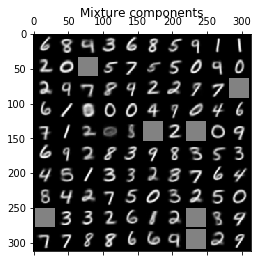

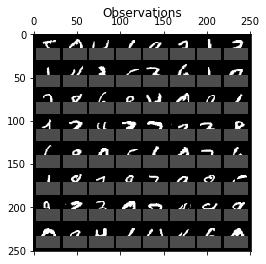

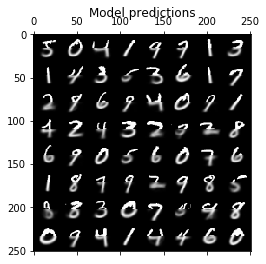

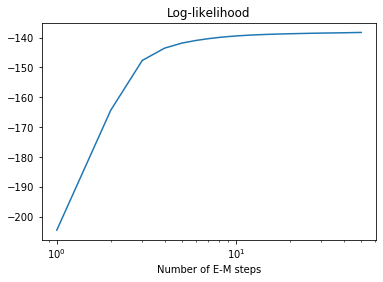

In [3]:
train_with_em()